In [1]:
# inversion calculation

In [2]:
# to display plots in notebook
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 300  # high res plots
rcParams["font.size"] = 12

import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import scipy.linalg as sp
import xarray as xr
import matplotlib.pyplot as plt
import re
import cartopy.crs as ccrs
import pandas as pd
import regionmask
from gamap_colormap import WhGrYlRd  # import the "WhGrYlRd" variable from my custom Python script

In [4]:
name_month = 'Jan' # Jan, Feb, Mar
imonth     =  1    # 1,2,3
mode       = 'N'  # 'N': Nadir or 'NG': Nadir + Glint

In [5]:
input_directory = '/geos/u73/msadiq/GEOS-Chem/analysis/python/data/'
output_directory = input_directory

if mode == 'N':
    delta_y0_file = 'delta_y0_model_N_' + name_month + '.nc'
    xco2_file = 'XCO2_mod_and_oco2_N_' + name_month + '.nc'
else:
    delta_y0_file = 'delta_y0_model_' + name_month + '.nc'
    xco2_file = 'XCO2_mod_and_oco2_' + name_month + '.nc'

In [6]:
# open datasets
ds_delta_y0 = xr.open_dataset(input_directory + delta_y0_file)
# read in delta y0 later
ds_xco2 = xr.open_dataset(input_directory + xco2_file)
xco2_oco2  = ds_xco2['xco2_oco2']
xco2_model = ds_xco2['xco2_model']
xco2_error = ds_xco2['xco2_error']
diff       = xco2_oco2 - xco2_model

In [7]:
# reduce the size of all arrays and matrices, from 400k to <10k
x = xco2_oco2.copy()
x = x[np.logical_not(np.isnan(x))]
ind = x.record.values   # index for slicing
length = len(ind)
print('reduced size of matrices and arrays: ' + str(length))

reduced size of matrices and arrays: 1554


In [8]:
# get a slice of arrays
diff_slice = diff[ind].values
xco2_error_slice = xco2_error[ind].values

In [9]:
# a priori error
del_X_f = np.zeros((22,22))
for idiag in range(22):
    del_X_f[idiag,idiag] = 1.0  # assumed to be 1 GrC/yr

# delta y0
del_Y_matrix = np.empty((length,22))
del_Y_matrix[:] = np.nan
for itag in range(22):
    name_var = 'X_SpeciesConc_CO2Tag' + str(itag+1)
    del_Y_matrix[:,itag] = ds_delta_y0[name_var][ind].values
    
# observation error
obs_error = np.zeros((length,length))
for idiag in range(length):
    obs_error[idiag, idiag] = xco2_error_slice[idiag]**2 + 2.5
    # measurment error from oco2
    # model error and representation error = 2.5 for land

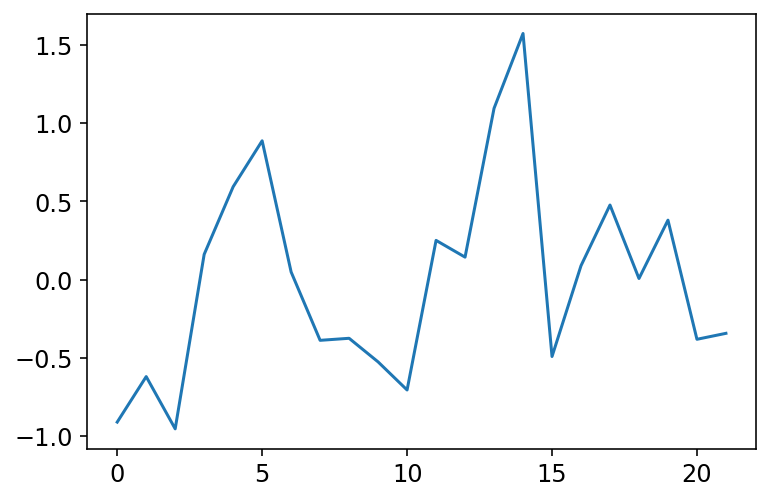

In [10]:
# calculation of first posterior
del_Y_tran = np.matrix.transpose(del_Y_matrix)
first      = np.matmul(del_Y_matrix,del_Y_tran)
second     = np.linalg.inv(first+obs_error)
third      = np.matmul(del_Y_tran,second)
k_e        = np.matmul(del_X_f,third) # kalman gain,
adjust     = np.matmul(k_e, diff_slice) # adjustment to prior
plt.plot(adjust)

In [11]:
df = pd.read_csv(input_directory + 'base_emission.csv')
region_names = df['name'].values
prior_emission = df['emission'].values

In [12]:
name_month = 'Jan' # Jan, Feb, Mar
imonth     =  1    # 1,2,3
mode       = 'N'  # 'N': Nadir or 'NG': Nadir + Glint

In [13]:
adjust_3months = np.zeros((3,22))
adjust_3months[0,:] = adjust*12/44

In [14]:
for i, name_month in enumerate(['Feb', 'Mar']):
    print('start of ' + name_month + ' inversion')
    
    if mode == 'N':
        delta_y0_file = 'delta_y0_model_N_' + name_month + '.nc'
        xco2_file = 'XCO2_mod_and_oco2_N_' + name_month + '.nc'
    else:
        delta_y0_file = 'delta_y0_model_' + name_month + '.nc'
        xco2_file = 'XCO2_mod_and_oco2_' + name_month + '.nc'
    
    # open datasets
    ds_delta_y0 = xr.open_dataset(input_directory + delta_y0_file)
    # read in delta y0 later
    ds_xco2 = xr.open_dataset(input_directory + xco2_file)
    xco2_oco2  = ds_xco2['xco2_oco2']
    xco2_model = ds_xco2['xco2_model']
    xco2_error = ds_xco2['xco2_error']
    diff       = xco2_oco2 - xco2_model
    
    # reduce the size of all arrays and matrices, from 400k to <10k
    x = xco2_oco2.copy()
    x = x[np.logical_not(np.isnan(x))]
    ind = x.record.values   # index for slicing
    length = len(ind)
    print('reduced size of matrices and arrays: ' + str(length))
    
    # get a slice of arrays
    diff_slice = diff[ind].values
    xco2_error_slice = xco2_error[ind].values

    tmp = np.identity(22) - np.matmul(third, del_Y_matrix)
    transform_mat = sp.sqrtm(tmp)
    del_X_a = np.matmul(del_X_f, transform_mat)
    del_X_f = del_X_a.copy()
    
    # delta y0
    del_Y_matrix = np.empty((length,22))
    del_Y_matrix[:] = np.nan
    for itag in range(22):
        name_var = 'X_SpeciesConc_CO2Tag' + str(itag+1)
        del_Y_matrix[:,itag] = ds_delta_y0[name_var][ind].values
    
    # observation error
    obs_error = np.zeros((length,length))
    for idiag in range(length):
        obs_error[idiag, idiag] = xco2_error_slice[idiag] + 2.5
    # measurment error from oco2
    # model error and representation error = 2.5 for land
    
    # calculation of posterior
    del_Y_tran = np.matrix.transpose(del_Y_matrix)
    first      = np.matmul(del_Y_matrix,del_Y_tran)
    second     = np.linalg.inv(first+obs_error)
    third      = np.matmul(del_Y_tran,second)
    k_e        = np.matmul(del_X_f,third)   # kalman gain,
    adjust     = np.matmul(k_e, diff_slice) # adjustment to prior
    
    adjust_3months[i+1,:] = adjust*12/44 # GtC/yr

start of Feb inversion
reduced size of matrices and arrays: 906
start of Mar inversion
reduced size of matrices and arrays: 1487


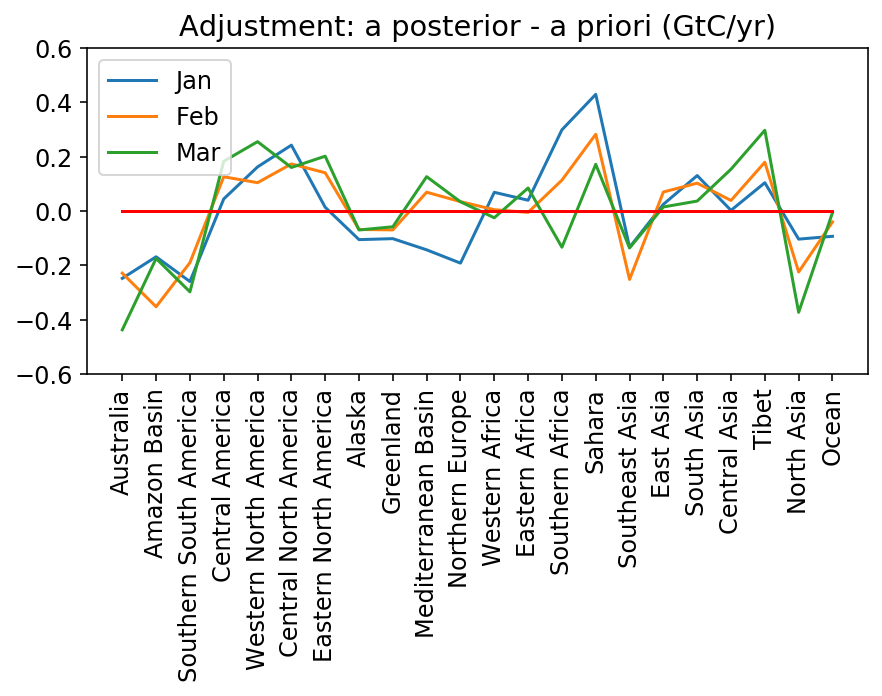

In [15]:
fig = plt.figure(figsize=[7, 3])
plt.plot(region_names, adjust_3months[0,:], label = 'Jan')
plt.plot(region_names, adjust_3months[1,:], label = 'Feb')
plt.plot(region_names, adjust_3months[2,:], label = 'Mar')
plt.plot(region_names, np.zeros(22), 'r')
plt.ylim(bottom = -0.6, top = 0.6)
plt.xticks(rotation = 90)
plt.title('Adjustment: a posterior - a priori (GtC/yr)')
plt.legend(loc=2)

fig.savefig(output_directory+'adjust_3months.png', dpi=300, bbox_inches='tight')

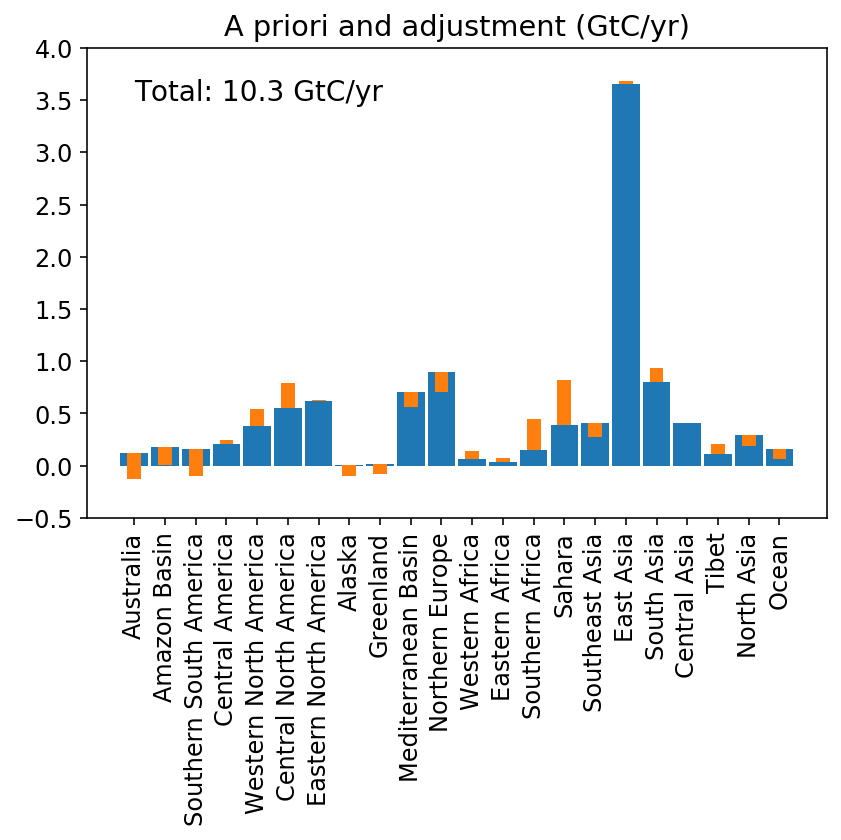

In [16]:
fig = plt.figure(figsize=[6, 6])
width = 0.9
plt.bar(region_names, prior_emission, width)
plt.bar(region_names, adjust_3months[0,:], width*0.5, bottom = prior_emission)
plt.ylim(top = 4,bottom = -0.5)
plt.title('A priori and adjustment (GtC/yr)')
plt.xticks(rotation=90)
plt.text(x='Australia', y=3.5, s='Total: 10.3 GtC/yr', size = 14)
fig.tight_layout()

fig.savefig(output_directory+'posterior_' + name_month +'.png', dpi=300)

In [17]:
err_reduc = np.zeros(22)
p_X_a = np.matmul(del_X_a, np.matrix.transpose(del_X_a))
for iregion in range(22):
    err_reduc[iregion] = 1 - np.sqrt(p_X_a[iregion,iregion])/1
err_reduc

array([0.1483443 , 0.15230277, 0.19367707, 0.45859537, 0.43766357,
       0.43045262, 0.24096101, 0.0438702 , 0.04334581, 0.69973749,
       0.52230233, 0.05667683, 0.07010651, 0.44279132, 0.73030709,
       0.29956282, 0.94286372, 0.91460568, 0.71100164, 0.23515527,
       0.0642747 , 0.04301301])

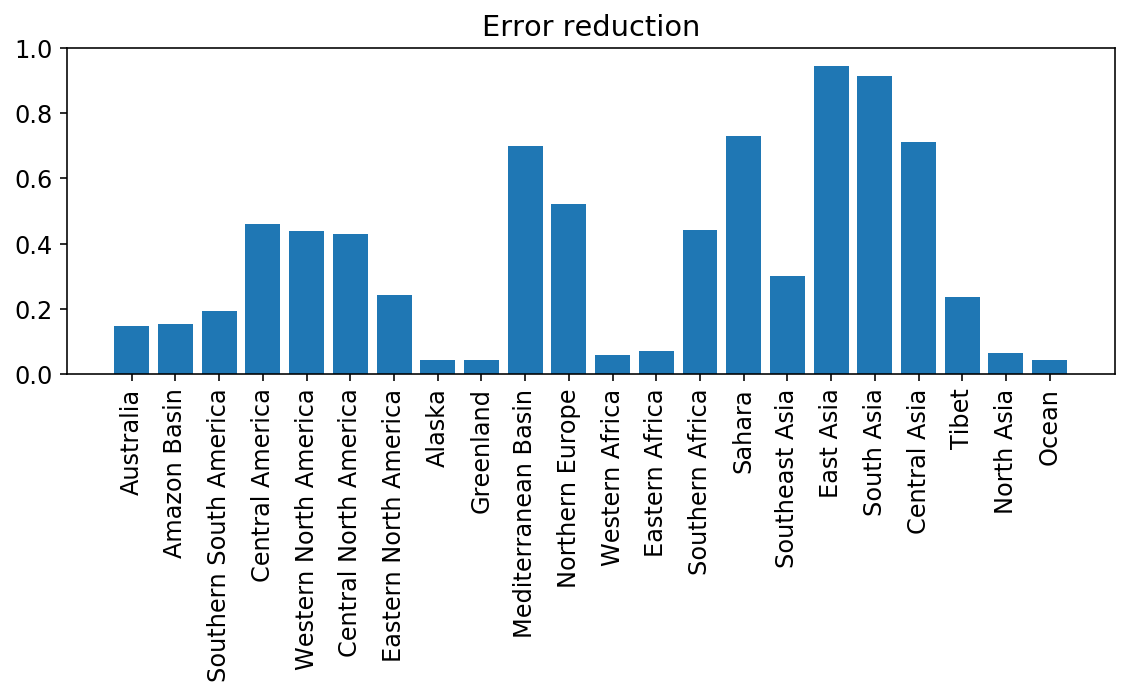

In [18]:
fig = plt.figure(figsize=[8, 5])
plt.bar(region_names, err_reduc)
plt.ylim(top= 1,bottom = 0)
plt.title('Error reduction')
plt.xticks(rotation=90)
fig.tight_layout()

fig.savefig(output_directory+'err_red_barchart.png', dpi=300)

In [19]:
# 1, get a mask
input_file = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/CO2-2018-03/OutputDir/GEOSChem.SpeciesConc.20180128_0000z.nc4'
ds_input   = xr.open_dataset(input_file)
dr  = ds_input['SpeciesConc_CO2'].isel(lev=0)
mask = regionmask.defined_regions.giorgi.mask(dr)

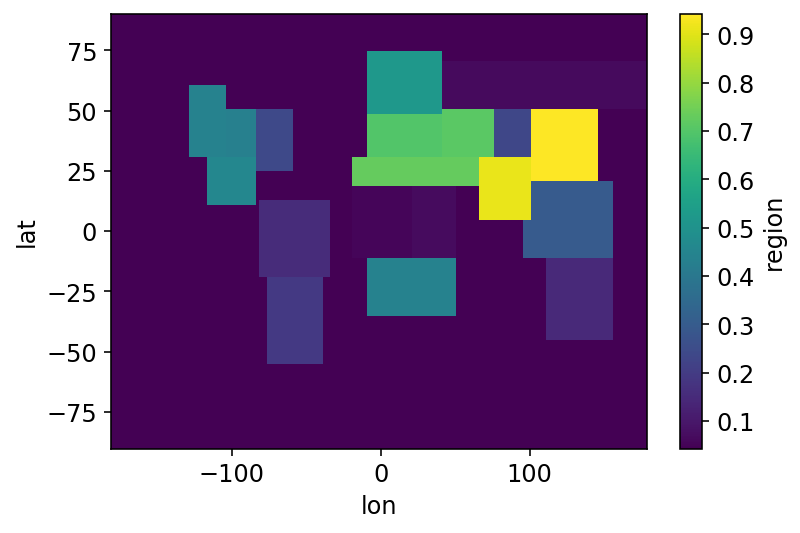

In [20]:
# map error reduction data to mask map
for ilon in range(len(mask.lon)):
    for ilat in range(len(mask.lat)):
        if(np.isnan(mask[ilat,ilon].values)):
            mask[ilat,ilon] = err_reduc[21]
            continue
        val = int(mask[ilat,ilon].values)
        mask[ilat,ilon] = err_reduc[val-1]
mask.plot()

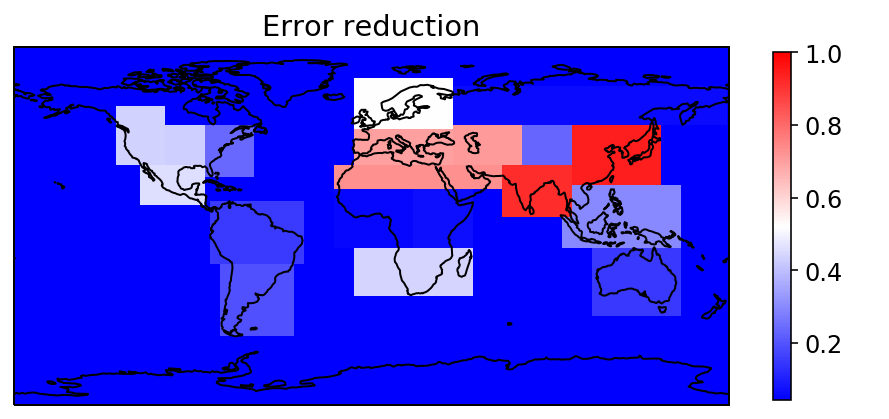

In [21]:
# plot of error reduction
fig = plt.figure(figsize=[8, 4])

proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

mask.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='bwr', vmax = 1, cbar_kwargs={'shrink': 0.8, 'label': ' '})
ax.set_title("Error reduction")
ax.coastlines();

fig.savefig(output_directory+'err_red.png', dpi=300)